# SN Global

This notebook is a detailed work through showing how the Signal-to-Noise is calulcated. The methods outlined below are by no means as the final method used, but are just to show working

This notebook contains:
* First analysis of SN on global level.
* Sample plots prooving the S/N method works.
* Plots useful for presentations outlining how the method works.


# Preamble

In [1]:
import numpy as np
import os
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import xarray as xr
from importlib import reload
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from dask.diagnostics import ProgressBar

In [2]:
import sys
import constants
sys.path.append(constants.MODULE_DIR)
import xarray_class_accessors as xca
import signal_to_noise
import sn_plotting 
from classes import ExperimentTypes
import open_ds
from utils import pprint_list
from warnings import filterwarnings
filterwarnings('ignore')
import utils

In [3]:
# The directory where all of the longrun mip data used in this notebook is stored.
variable = 'tas'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable, 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped'

In [4]:
IMG_DIR = constants.IMAGE_SAVE_DIR_TOP_LEVEL
notebook_number ='01'
model = 'CCSM3'
WINDOW = 51

In [5]:
# Set-up logging for notebook
logger = utils.get_notebook_logger()
utils.change_logging_level('DEBUG')

In [6]:
logger.debug('Test')

Test


# Control
THe SN for the piControl is get the stable/unstable bounds for each gridcell. This is to work out what can be considered natural variabilbity of the system.

In [7]:
pprint_list(os.listdir(ROOT_DIR), num_start_items=3)

lenght = 32
 0. tas_ann_HadGEM2_control_239_g025.nc
 1. tas_mon_HadCM3L_control_1000_g025.nc
 2. tas_mon_GFDLCM3_control_5200_g025.nc


In [8]:
fname = 'tas_mon_CCSM3_control_1530_g025.nc'

In [9]:
model = fname.split('_')[2]
model

'CCSM3'

In [10]:
control = xr.open_dataset(os.path.join(ROOT_DIR, fname), use_cftime=True).tas
abrupt = xr.open_dataset(os.path.join(ROOT_DIR,'tas_mon_CCSM3_abrupt4x_2120_g025.nc' ), use_cftime=True).tas

In [11]:
control

<xarray.DataArray 'tas' (time: 1530, lat: 72, lon: 144)>
[15863040 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1530-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [12]:
abrupt 

<xarray.DataArray 'tas' (time: 2120, lat: 72, lon: 144)>
[21980160 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 2120-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [13]:
reload(xca)
reload(signal_to_noise)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/modules/signal_to_noise.py'>

In [31]:
# Anomalias
control_anom = control.clima.anomalies()

# Global Mean (space mean)
control_anom_smean = control_anom.clima.space_mean()
control_anom_smean = control_anom_smean.isel(time=slice(12,None)) # TODO: First part is bugged

# Signal
control_anom_smean_signal = control_anom_smean.sn.calculate_rolling_signal(window = WINDOW, 
                                                                           logginglevel='DEBUG')

# Lowess filter
control_anom_smean_loess = control_anom_smean.sn.apply_loess_filter(window=WINDOW)

# Noise
control_anom_smean_noise = control_anom_smean_loess.sn.calculate_rolling_noise(window=WINDOW, 
                                                                           logginglevel='DEBUG')

# The signal to noise for the control anomlaies.
control_anom_smean_sn = control_anom_smean_signal/control_anom_smean_noise

control_smean_lbound, control_smean_ubound =\
            signal_to_noise.calculate_upper_and_lower_bounds(control_anom_smean_sn, 
                                                                           logginglevel='DEBUG')

Calculting the rolling signal
Adjusting time points by 25
Calculting the rolling noise
Adjusting time points by 25
Calculating Upper and lower control bounds
np.nanpercentile used
-2.055462431702793  - 1.65751146158821


In [15]:
# Anomalis
abrupt_anom = abrupt.clima.anomalies(historical=control)

# Globab mean
abrupt_anom_smean = abrupt_anom.clima.space_mean()

# Signal
abrupt_anom_smean_signal = abrupt_anom_smean.sn.calculate_rolling_signal(window = WINDOW)

# Lowess
abrupt_anom_smean_loess = abrupt_anom_smean.sn.apply_loess_filter(window= WINDOW)

# Noise 
abrupt_anom_smean_noise = abrupt_anom_smean_loess.sn.calculate_rolling_noise(window = WINDOW)

# Signal-to-Noise
abrupt_anom_smean_sn = abrupt_anom_smean_signal/abrupt_anom_smean_noise
abrupt_anom_smean_sn

<xarray.DataArray (time: 2070)>
array([ 9.66132583, 10.35683794, 10.27091848, ..., -1.60138177,
       -1.36977823, -1.25606645])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 2070-12-31 00:00:00

In [39]:
abrupt_anom_smean_stable, abrupt_anom_smean_unstable, da_sn_decreasing = \
                                    signal_to_noise.get_ds_above_below_and_between_bounds(
                                      abrupt_anom_smean, abrupt_anom_smean_sn, 
                                      control_smean_lbound, control_smean_ubound)

abrupt_anom_smean_sn_stable, da_sn_increasing, da_sn_decreasing = \
                                    signal_to_noise.get_ds_above_below_and_between_bounds(
                                      abrupt_anom_smean_sn, abrupt_anom_smean_sn, 
                                      control_smean_lbound, control_smean_ubound)

In [41]:
# Manual Calculation for Demonstations

# Sample period is the years that we want to look at
sample_period = (0,61) #(1200,1261)

# The length of the sample_period varible
window_length = np.diff(sample_period)[0]

# Subset
sample_data = abrupt_anom_smean.isel(time=slice(*sample_period))

# Gradient and y-intercept of the sample data (use=[0,1] will return grad and y intercept)
gradient_sp, yintercept_sp = xca.SignalToNoise.trend_line(sample_data.values, use=[0,1])
print(f'{gradient_sp=}, {yintercept_sp=}')

# Trend line (fitted_line) for the sample data to demonstrate method is working.
x_values = np.arange(len(sample_data.time.values))
fitted_line = gradient_sp * x_values + yintercept_sp

# Loess filtered 4xabrupt anomalies space mean. 
yhat = xca.SignalToNoise.loess_filter(abrupt_anom_smean.values, window = 51)

# Calculating the signal for the sample point
signal_sp = gradient_sp * window_length
print(f'{signal_sp=}')

gradient_sp=0.01642267837655539, yintercept_sp=2.8119075092797807
signal_sp=1.0017833809698788


# Plots

## Control

locator: <matplotlib.ticker.AutoLocator object at 0x7f3646d7edc0>


Text(0.5, 1.0, 'Signal-to-Noise')

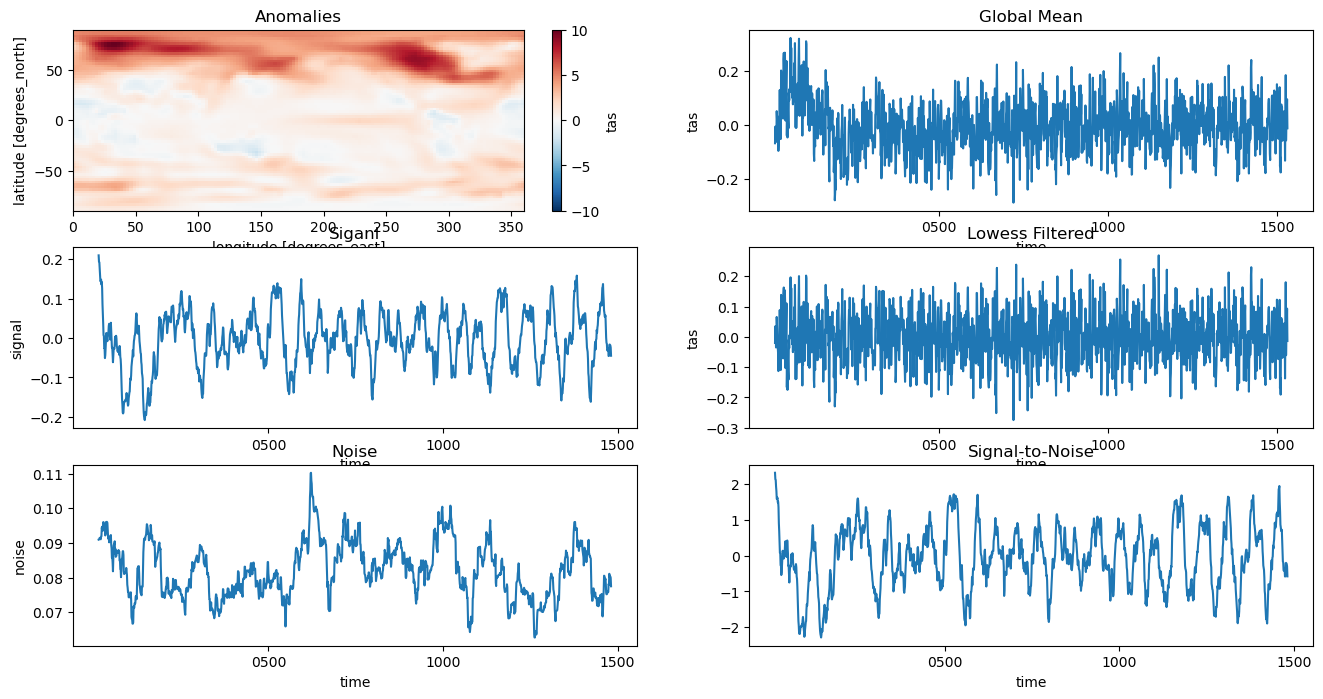

In [53]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3,ncols=2, figsize=(16,8))
control_anom.isel(time=0).plot(ax=ax1)
ax1.set_title('Anomalies')
control_anom_smean.plot(ax=ax2)
ax2.set_title('Global Mean')
control_anom_smean_signal.plot(ax=ax3)
ax3.set_title('Siganl')
control_anom_smean_loess.plot(ax=ax4)
ax4.set_title('Lowess Filtered')
control_anom_smean_noise.plot(ax=ax5)
ax5.set_title('Noise')
control_anom_smean_sn.plot(ax=ax6)
ax6.set_title('Signal-to-Noise')

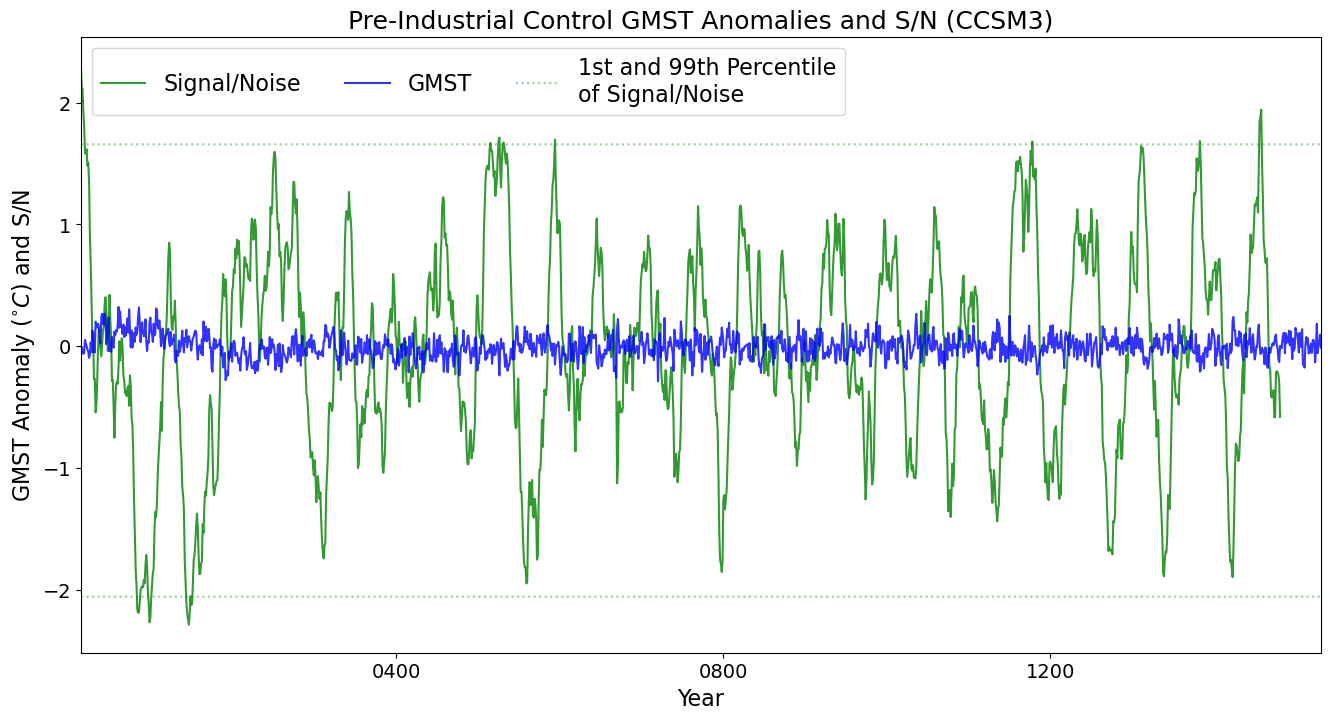

In [43]:
fig = plt.figure(figsize=(16,8))
ax = plt.gca()
control_anom_smean_sn.plot(label='Signal/Noise', ax=ax, color='green', alpha=0.8)
control_anom_smean.plot(label='GMST', ax=ax, color='blue', alpha=0.8)

time = control_anom_smean.time.values

ax.plot(time, [control_smean_lbound.values] * len(control_anom_smean.time.values), 
        label='1st and 99th Percentile\nof Signal/Noise',
       c='green', linestyle =':', alpha=0.4)

ax.plot(time, [control_smean_ubound.values] * len(control_anom_smean.time.values),
       c='green', linestyle =':', alpha=0.4)

ax.set_xlim(time[0], time[-1])
ax.legend(ncol=4, fontsize=16)
ax.set_ylabel(r'GMST Anomaly ($^{\circ}C$) and S/N', size=16);
ax.set_xlabel('Year', size=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title(f'Pre-Industrial Control GMST Anomalies and S/N ({model})', size=18)

fig.savefig(f'{IMG_DIR}/{notebook_number}_piControl_SN.png', dpi=200)

## Abrupt4x

In [44]:
sample_period_2 = (0, 200000)

Text(0.5, 1.0, 'Signal-to-Noise')

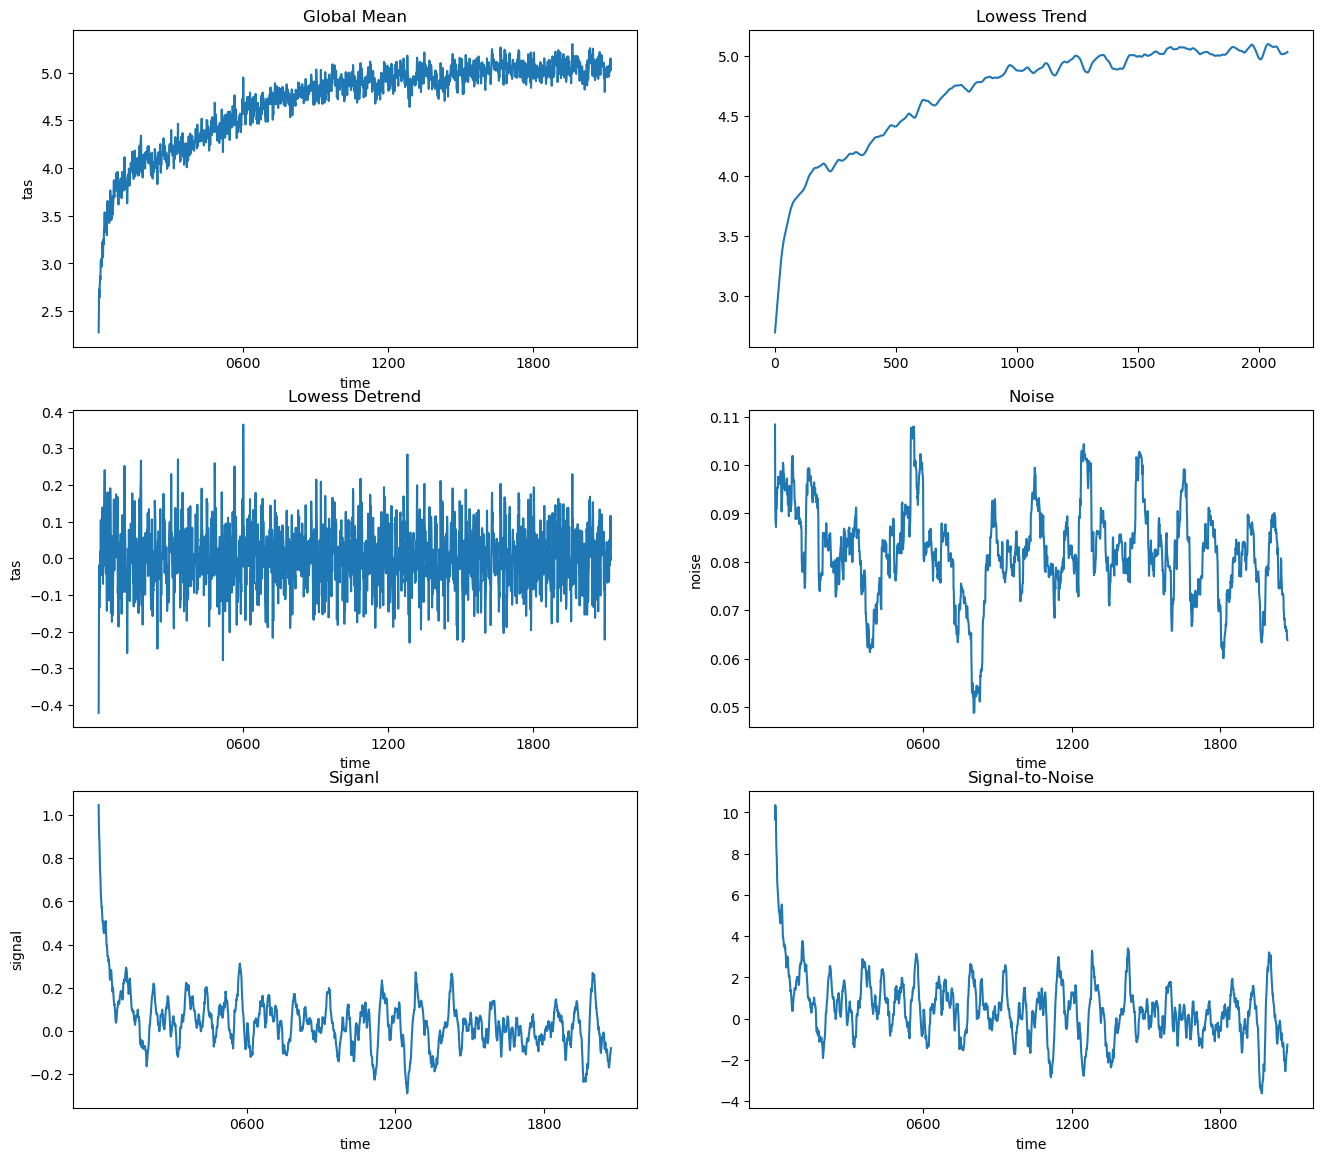

In [45]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3,ncols=2, figsize=(16,14))
abrupt_anom_smean.plot(ax=ax1)
ax1.set_title('Global Mean')
ax2.plot(yhat)
ax2.set_title('Lowess Trend')
abrupt_anom_smean_loess.plot(ax=ax3)
ax3.set_title('Lowess Detrend')
abrupt_anom_smean_noise.plot(ax=ax4)
ax4.set_title('Noise')
abrupt_anom_smean_signal.plot(ax=ax5)
ax5.set_title('Siganl')
abrupt_anom_smean_sn.plot(ax=ax6)
ax6.set_title('Signal-to-Noise')

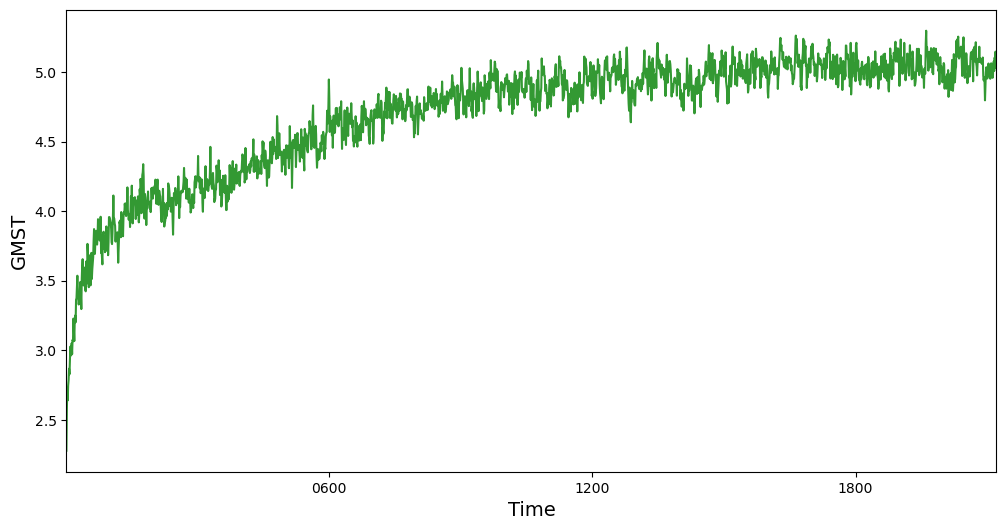

In [46]:
# A nice plot of the space mean
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
abrupt_anom_smean.plot(ax = ax, color='green', alpha = 0.8)
ax.set_xlim(abrupt_anom_smean.time.values[0], abrupt_anom_smean.time.values[-1])
ax.set_xlabel('Time', size=14)
ax.set_ylabel('GMST', size=14)
fig.savefig(f'{IMG_DIR}/{notebook_number}_GMST.png', dpi=200)

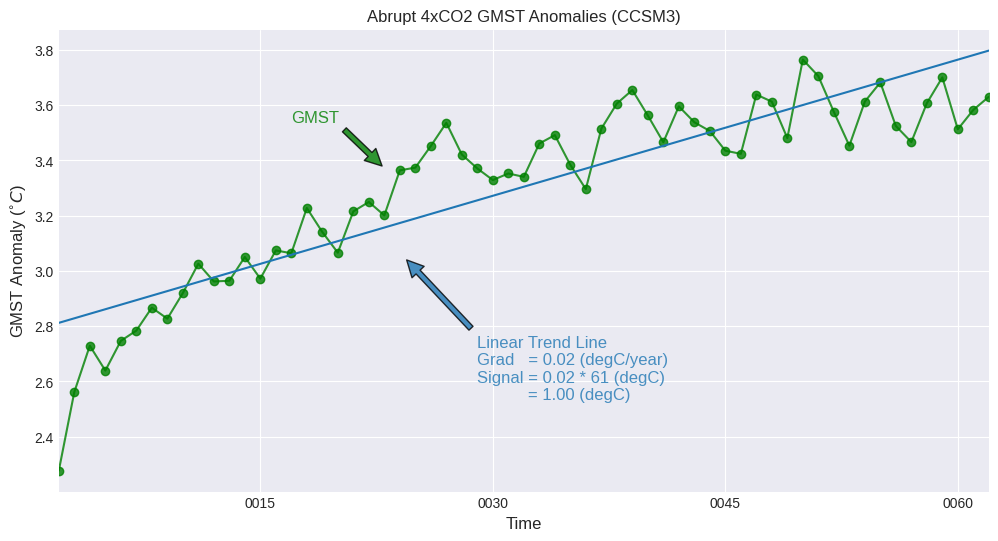

In [47]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
sample_data.plot(ax = ax, color='green', alpha = 0.8, marker='o', label='GMST')
ax.plot(sample_data.time.values, fitted_line,
        label=f'Linear Trend Line\nGrad = {gradient_sp:.2f}\nSignal {signal_sp:.2f}')
ax.set_xlim(sample_data.time.values[0], sample_data.time.values[-1])
ax.set_xlabel('Time', size=12)
ax.set_ylabel(r'GMST Anomaly ($^{\circ}C$)', size=12)
# ax.legend(ncol=2);


c_gmst = plt.gca().lines[0].get_color()
ax.annotate('GMST', xy = (0.35, 0.7), xycoords='axes fraction', size=12, c=c_gmst, alpha=0.8,
            xytext = (0.25, 0.8),
           arrowprops=dict(facecolor=c_gmst, shrink=0.05, alpha=0.8))


c_line = plt.gca().lines[1].get_color()
text = f'Linear Trend Line\nGrad   = {gradient_sp:.2f} (degC/year)\nSignal = {gradient_sp:.2f} * {window_length} (degC)\n           = {signal_sp:.2f} (degC)'
ax.annotate(text,
            xy = (0.37, 0.51), xycoords='axes fraction', size=12, c=c_line, alpha=0.8,
            xytext = (0.45, 0.2),
           arrowprops=dict(facecolor=c_line, shrink=0.05, alpha=0.8))

ax.set_title(f'Abrupt 4xCO2 GMST Anomalies ({model})');


fig.savefig(f'{IMG_DIR}/{notebook_number}_GMST_Signal.png', dpi=200)

top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved
top of Axes not in the figure, so title not moved


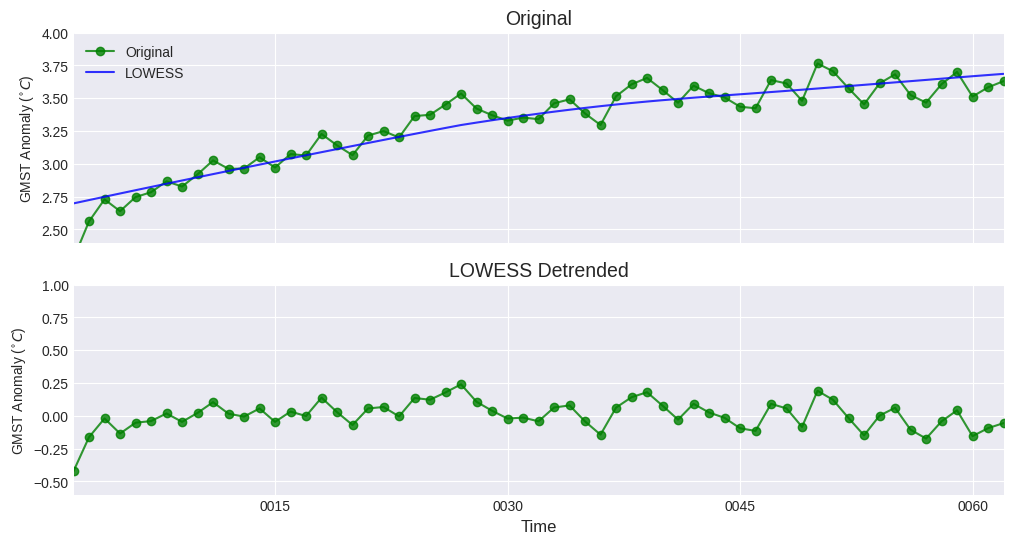

In [48]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,1,1)
abrupt_anom_smean.isel(time=slice(*sample_period)).plot(ax=ax1, label='Original', color='green', marker='o'
                                                       ,alpha=0.8)
ax1.plot(sample_data.time.values[sample_period[0]:sample_period[-1]],
         yhat[sample_period[0]:sample_period[-1]], label='LOWESS', color='blue',alpha=0.8)
ax1.set_ylim([2.4,4])
ax1.set_title('Original', fontsize=14)
ax1.set_xlabel('')
ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax1.set_ylabel(r'GMST Anomaly ($^{\circ}C$)')
ax1.legend()

ax2 = fig.add_subplot(2,1,2)
abrupt_anom_smean_loess.isel(time=slice(*sample_period)).plot(ax=ax2, color='green', marker='o',alpha=0.8)
ax2.set_ylim([-0.6, 1])
ax2.set_title('LOWESS Detrended', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel(r'GMST Anomaly ($^{\circ}C$)')

ax1.set_xlim(sample_data.time.values[0], sample_data.time.values[-1]);
ax2.set_xlim(sample_data.time.values[0], sample_data.time.values[-1]);

fig.savefig(f'{IMG_DIR}/{notebook_number}_GMST_lowess.png', dpi=200)

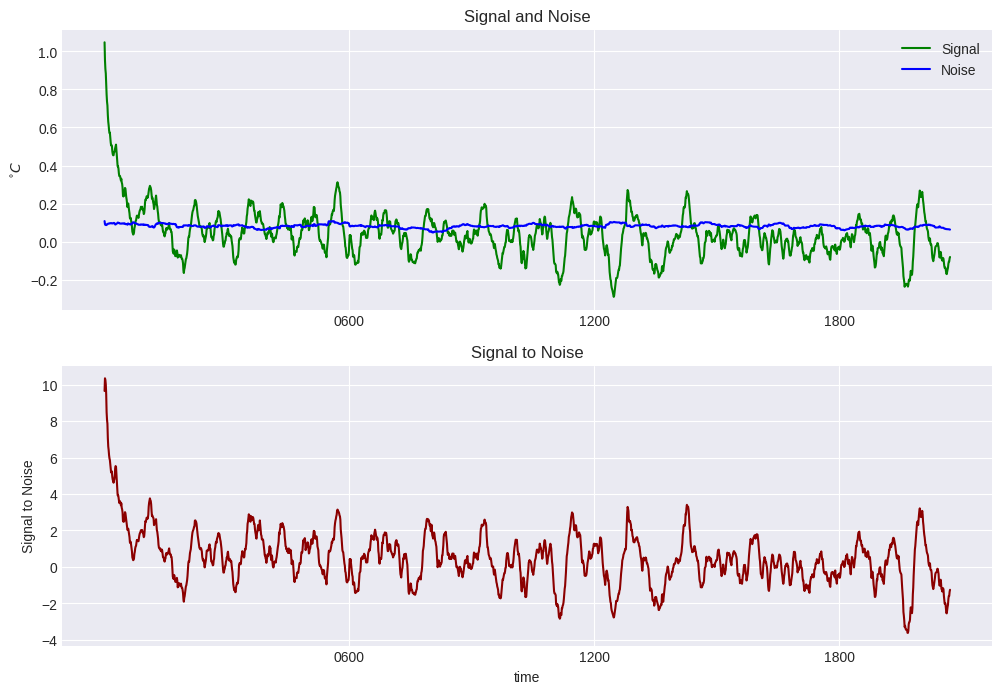

In [49]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(211)
abrupt_anom_smean_signal.isel(time=slice(*sample_period_2)).plot(ax=ax, color='green', label='Signal')
abrupt_anom_smean_noise.isel(time=slice(*sample_period_2)).plot(ax = ax, color='blue', label='Noise')
ax.set_title('Signal and Noise')
ax.set_ylabel(r'$^{\circ}C$')
ax.set_xlabel('')
ax.legend()

ax2 = fig.add_subplot(212)
abrupt_anom_smean_sn.isel(time=slice(*sample_period_2)).plot(ax = ax2, color='darkred')
ax2.set_title('Signal to Noise')
ax2.set_ylabel('Signal to Noise')

fig.savefig(f'{IMG_DIR}/{notebook_number}_GMST_Signal_Npng', dpi=200)

In [50]:
bounds = {'lower': control_smean_lbound.values, 'upper': control_smean_ubound.values}
bounds

{'lower': array(-2.05546243), 'upper': array(1.65751146)}

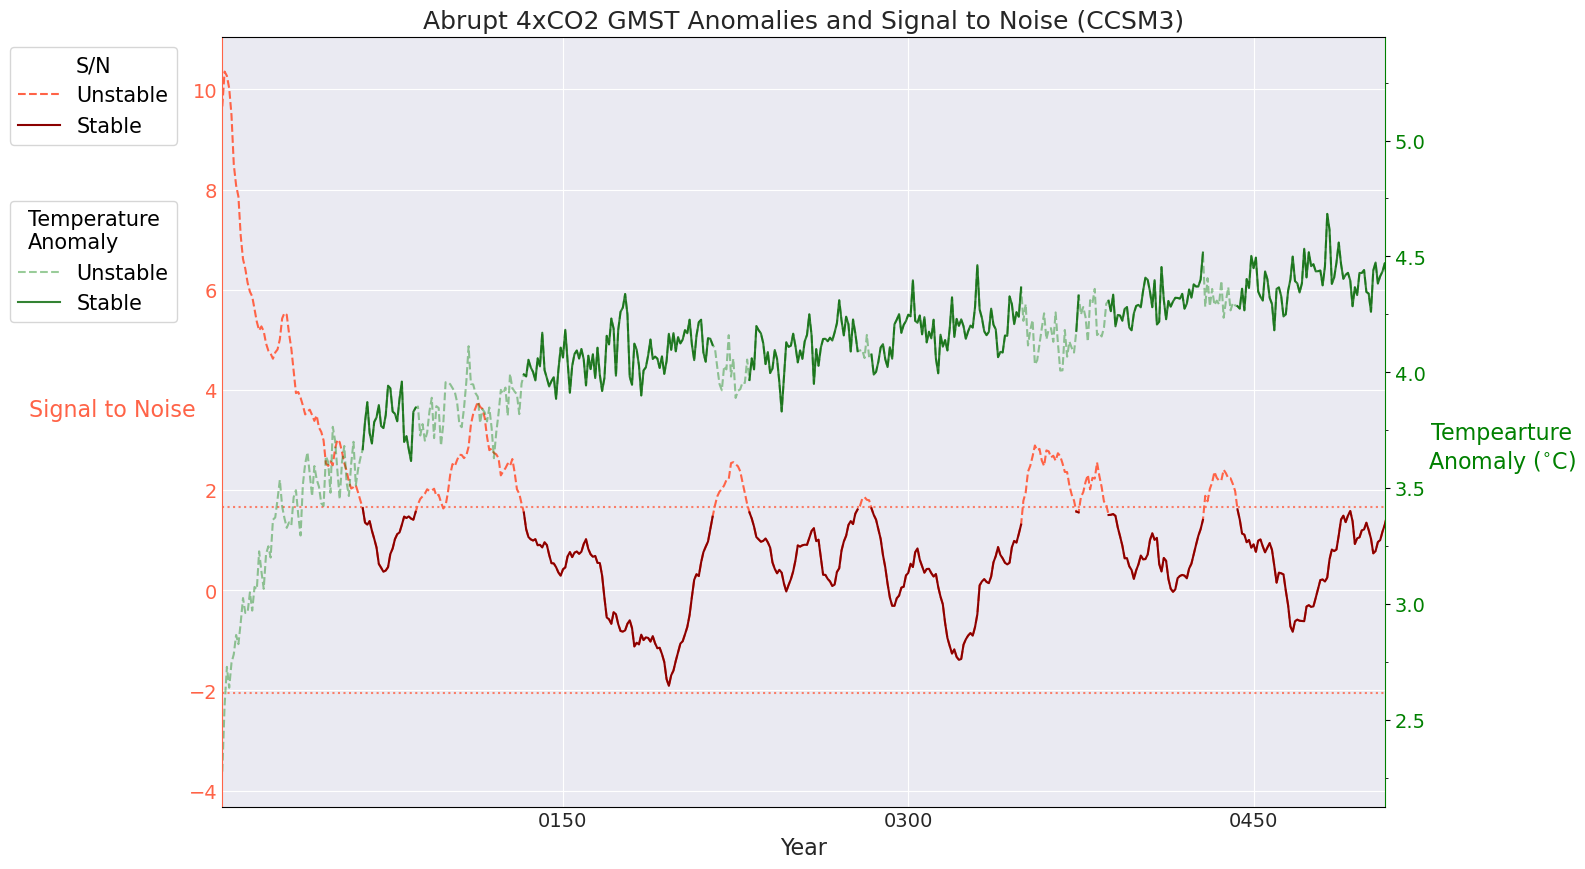

In [51]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn, abrupt_anom_smean,
                      temp_highlight = abrupt_anom_smean_stable, 
                      sn_highlight = abrupt_anom_smean_sn_stable, 
                              bounds = bounds)

ax.set_xlim(abrupt_anom_smean_sn.time.values[0], abrupt_anom_smean_sn.time.values[505])
ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=18);

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_global_sn_temp_anomaly_t500.png', bbox_inches='tight', dpi=200)

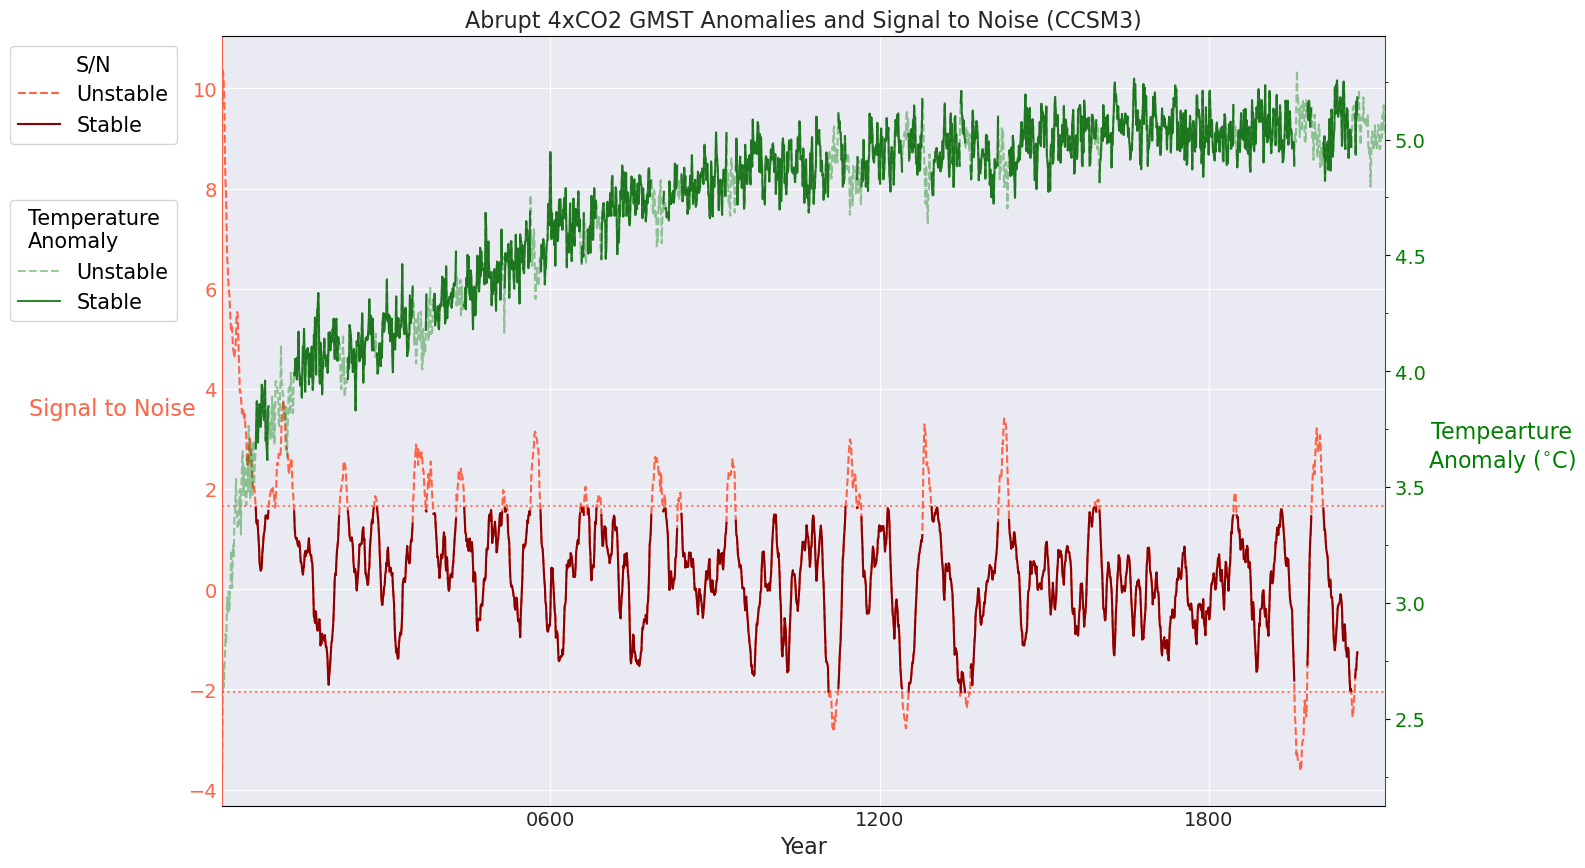

In [52]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn, abrupt_anom_smean,
                      temp_highlight = abrupt_anom_smean_stable, 
                      sn_highlight = abrupt_anom_smean_sn_stable, bounds=bounds)

ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=16);

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_global_sn_temp_anomaly.png', bbox_inches='tight', dpi=500)